# AIPI 590 - XAI | Mechanistic Interpretability
### A tiny neural network for XOR classification
### Mariam Khan

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mkhan13/XAI/blob/main/mechanistic_interpretability.ipynb
)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# **Part 1 - Setup**

### XOR Data Generation

In [34]:
X = torch.tensor([[0,0],[0,1],[1,0],[1,1]], dtype=torch.float32)
y = torch.tensor([[0],[1],[1],[0]], dtype=torch.float32)

### Build a Tiny MLP (multilayer perceptron) Model

In [46]:
class TinyXOR(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 4)
        self.out = nn.Linear(4, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        hidden = torch.sigmoid(self.hidden(x))
        pred = torch.sigmoid(self.out(hidden))
        return pred, hidden

model = TinyXOR()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

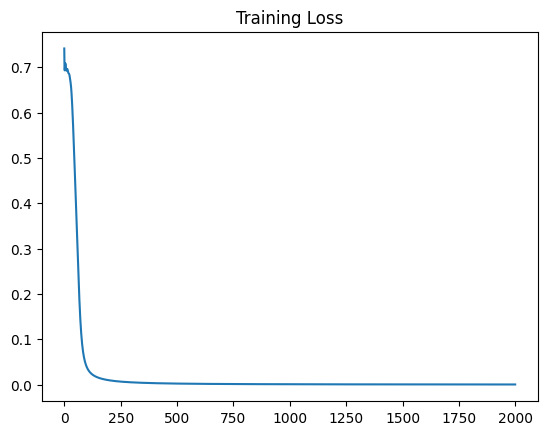

In [47]:
# Train
losses = []
for epoch in range(2000):
    optimizer.zero_grad()
    pred, hidden = model(X)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.title("Training Loss")
plt.show()

### Test predictions

In [48]:
with torch.no_grad():
    pred, hidden = model(X) # Get predictions and hidden activations
print(torch.round(pred))

tensor([[0.],
        [1.],
        [1.],
        [0.]])


# **Part 2 - Explore**

### Get hidden layer activations

In [49]:
hidden = hidden.numpy() # Convert tensor to numpy
print("Hidden layer activations:")
print(hidden)

Hidden layer activations:
[[7.6586926e-01 4.6739198e-02 8.4170401e-01 1.3527897e-01]
 [9.9999332e-01 9.9420148e-01 1.2984235e-03 9.9854565e-01]
 [6.0834354e-03 5.7910245e-07 9.8339410e-04 9.9912077e-01]
 [9.9643964e-01 2.0210056e-03 2.4068316e-07 9.9999976e-01]]


### Hidden layer activations bar plot

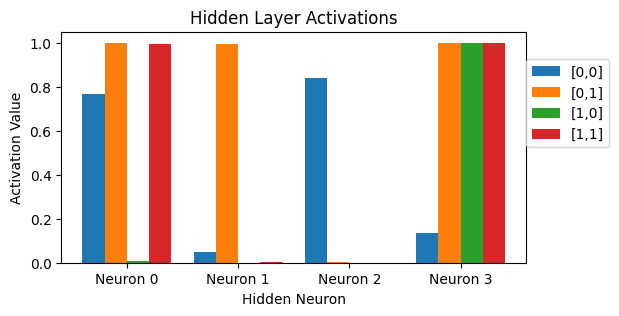

In [50]:
plt.figure(figsize=(6,3))
x_positions = np.arange(hidden.shape[1])

for index, label in enumerate(["[0,0]", "[0,1]", "[1,0]", "[1,1]"]):
    plt.bar(x_positions + index*0.2, hidden[index], width=0.2, label=label)

plt.xticks(x_positions + 0.3, [f"Neuron {i}" for i in range(hidden.shape[1])])
plt.legend(loc=(1, 0.5))
plt.xlabel("Hidden Neuron")
plt.ylabel("Activation Value")
plt.title("Hidden Layer Activations")
plt.show()

### Get weights and biases

In [51]:
weight_hidden = model.hidden.weight.data.numpy()
bias_hidden = model.hidden.bias.data.numpy()

weight_out = model.out.weight.data.numpy()
bias_out = model.out.bias.data.numpy()

print("Hidden Layer Weights:")
print(weight_hidden)
print("Hidden Layer Biases:")
print(bias_hidden)
print("Output Layer Weights:")
print(weight_out)
print("Output Layer Bias:")
print(bias_out)

Hidden Layer Weights:
[[ -6.2812157  10.730423 ]
 [-11.34648     8.159649 ]
 [ -8.594479   -8.316267 ]
 [  8.890671    8.386811 ]]
Hidden Layer Biases:
[ 1.1851318 -3.0153053  1.6709617 -1.8550678]
Output Layer Weights:
[[-16.187096   16.76247    -3.7020023   7.2285833]]
Output Layer Bias:
[1.0192945]


### Hidden layer weights heatmap

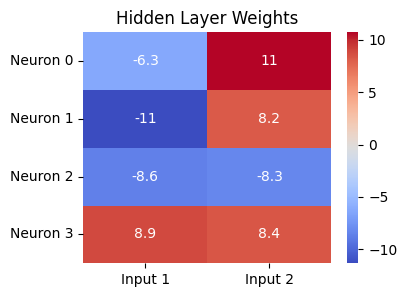

In [54]:
plt.figure(figsize=(4,3))
sns.heatmap(weight_hidden, annot=True, cmap="coolwarm",
            xticklabels=["Input 1", "Input 2"],
            yticklabels=[f"Neuron {i}" for i in range(weight_hidden.shape[0])])
plt.title("Hidden Layer Weights")
plt.show()

### Hidden layer biases bar plot

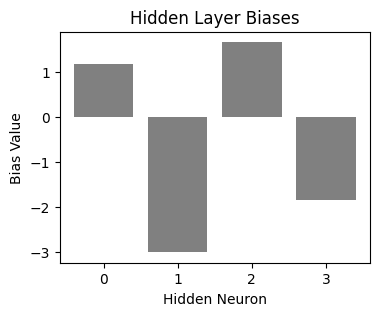

In [55]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(len(bias_hidden)), bias_hidden, color='gray')
plt.xlabel("Hidden Neuron")
plt.ylabel("Bias Value")
plt.title("Hidden Layer Biases")
plt.show()

### Output layer weights heatmap

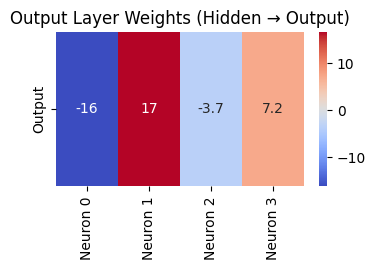

In [56]:
plt.figure(figsize=(4,2))
sns.heatmap(weight_out, annot=True, cmap="coolwarm",
            xticklabels=[f"Neuron {i}" for i in range(weight_out.shape[1])],
            yticklabels=["Output"])
plt.title("Output Layer Weights (Hidden → Output)")
plt.show()

### Identify one meaningful neuron

In [57]:
neuron_index = 2
print(f"Neuron {neuron_index} weights:", weight_hidden[neuron_index])
print(f"Neuron {neuron_index} bias:", bias_hidden[neuron_index])
print(f"Neuron {neuron_index} activations:", hidden[:, neuron_index])

Neuron 2 weights: [-8.594479 -8.316267]
Neuron 2 bias: 1.6709617
Neuron 2 activations: [8.4170401e-01 1.2984235e-03 9.8339410e-04 2.4068316e-07]


**Mechanistic hypothesis:** Neuron 2 is a NOR detector that focuses on detecting when there is no active input, meaning the input is [0,0]

# **Part 3 - Explain**

The hidden layer activations graph shows the learned function of each neuron. Neuron 0 has high acctivation for [0,0], [0,1], and [1,1]. Neuron 1 is a specialized detector that strongly activates only for [0,1]. Neuron 2 is a NOR detector that fires only for [0,0]. Neuron 3 is an OR detector that fires when any input is 1. The output weights combine these features to produce an XOR classification.

This is interesting because, despite having 4 neurons for 4 inputs, the neuron does not match a neuron to each input. Instead the network uses a mix of OR, NOR, and specialized detectors to cover all input cases.

# **Part 4 - Reflect**